In [2]:
%matplotlib inline
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
import numpy as np
import copy
import tqdm
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import librosa as lb
import time
import cProfile
import os
import os.path
import pyximport; pyximport.install()
import multiprocessing
from ExtractBootlegFeatures import *
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
import pretty_midi
import pickle
import random
import operator

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


# Load Rindex

In [4]:
# st = time.time()
# pickle_file = 'experiments/indices/N_GRAM_4_ALL.pkl'
# #pickle_file = 'experiments/indices/SINGULAR_1.pkl'
# with open(pickle_file, 'rb') as f:
#     rindex1 = pickle.load(f)
# print("LOADED pkl file")
# rindex_filter = rindex1
# print("Total Time: ",time.time()-st)

In [4]:
# condense = False
# if condense :
#     rindex_filter = copy.deepcopy(rindex1)
#     for key in rindex1:
#         s = 0
#         for piece in rindex1[key].keys():
#             s +=len(rindex1[key][piece])
#         if s > 10000:
#             rindex_filter.pop(key, None)
# print("Total Time: ",time.time()-st)

In [5]:
# st = time.time()
# Max_N = 4
# rindex_filter = []
# fpMaps = []
# counts = []
# for i in range(1, Max_N+1):
#     print("LOADING {}".format(i))
#     pickle_file = 'experiments/indices/N_GRAM_{}_ALL.pkl'.format(i)
#     count_file = 'experiments/indices/N_GRAM_{}_COUNT.pkl'.format(i)
#     with open(pickle_file, 'rb') as f:
#         rindex_filter.append(pickle.load(f))
#         f.flush()
#         f.close()
#     with open(count_file, 'rb') as f:
#         counts.append(pickle.load(f))
#         f.flush()
#         f.close()
# print("LOADED pkl files")
# print("Total Time: ",time.time()-st)

# Analysis 1

In [ ]:
st = time.time()
pickle_files = []
rindices = []
pickle_files.append('experiments/indices/N_GRAM_1_COUNT.pkl')
pickle_files.append('experiments/indices/N_GRAM_2_COUNT.pkl')
pickle_files.append('experiments/indices/N_GRAM_3_COUNT.pkl')
pickle_files.append('experiments/indices/N_GRAM_4_COUNT.pkl')
pickle_files.append('experiments/indices/N_GRAM_5_COUNT.pkl')
for pickle_file in pickle_files:
    with open(pickle_file, 'rb') as f:
        rindices.append(pickle.load(f))
print("LOADED pkl counts file")
print("Total Time: ",time.time()-st)

In [52]:
x_axis = []
y_axis = []
for i in range(5):
    rindex = rindices[i]
    counts = []
    for i in rindex.keys():
        counts.append(rindex[i])
    counts = sorted(counts, reverse = True)
    x_axis.append(np.arange(len(counts)))
    y_axis.append(counts)

In [53]:
threshold = 10000
dynamic_counts = []

In [54]:
# print("1-GRAM")
# # get 1-GRAM fps less than threshold
# fails_1 = []
# for i in rindices[0].keys():
#     if rindices[0][i] < threshold:
#         dynamic_counts.append(rindices[0][i])
#     else:
#         fails_1.append(i)

# print("2-GRAM")
# # get 2-GRAM fps based off 1_GRAM fps
# valid_2 = []
# fails_2 = []
# fails_1 = set(fails_1)
# for i in tqdm.notebook.tqdm(rindices[1].keys()):
#     base_tuple = (i[0])
#     if base_tuple in fails_1:
#         valid_2.append(i)
# print(len(valid_2))
# for i in valid_2:
#     if rindices[1][i] < threshold:
#         dynamic_counts.append(rindices[1][i])
#     else:
#         fails_2.append(i)

# print("3-GRAM")        
# # get 3-GRAM fps based off 1_GRAM fps
# valid_3 = []
# fails_3 = []
# for i in rindices[2].keys():
#     base_tuple = (i[0], i[1])
#     if base_tuple in fails_2:
#         valid_3.append(i)
# for i in valid_3:
#     if rindices[2][i] < threshold:
#         dynamic_counts.append(rindices[2][i])
#     else:
#         fails_3.append(i)
        
# print("4-GRAM")
# # get 4-GRAM fps based off 1_GRAM fps
# valid_4 = []
# for i in rindices[1].keys():
#     base_tuple = (i[0], i[1], i[2])
#     if base_tuple in fails_1:
#         valid_4.append(i)
# for i in valid_4:
#     dynamic_counts.append(rindices[3][i])
# x_axis_dynamic = np.arange(dynamic_counts)

In [55]:
counts = []
for i in tqdm.tqdm(rindices[3].keys()):
    freq = rindices[3][i]
    if freq > threshold:
        counts.append(freq)
    else:
        prev_freq = freq
        base_tuple = (i[0], i[1], i[2])
        if base_tuple == (0,0,0):
            counts.append(prev_freq)
            continue
        freq = rindices[2][base_tuple]
        if freq > threshold:
            counts.append(prev_freq)
        else:
            prev_freq = freq
            base_tuple = (i[0], i[1])
            if base_tuple == (0,0):
                counts.append(prev_freq)
                continue
            freq = rindices[1][base_tuple]
            if freq > threshold:
                counts.append(prev_freq)
            else:
                prev_freq = freq
                base_tuple = (i[0],)
                if base_tuple == (0,):
                    counts.append(prev_freq)
                    continue
                freq = rindices[0][base_tuple]
                if freq > threshold:
                    counts.append(prev_freq)
                else:
                    counts.append(freq)
dynamic_counts = counts
dynamic_counts = sorted(dynamic_counts, reverse = True)
x_axis_dynamic = np.arange(len(dynamic_counts))

100%|██████████| 34194308/34194308 [28:53<00:00, 19728.12it/s]


In [56]:
with open("/home/dyang/analysis10k.txt", 'wb') as f:
    pickle.dump(dynamic_counts, f)

In [71]:
with open("/home/dyang/analysis10k.txt", 'rb') as f:
    dynamic_counts = pickle.load(f)
x_axis_dynamic = np.arange(len(dynamic_counts))

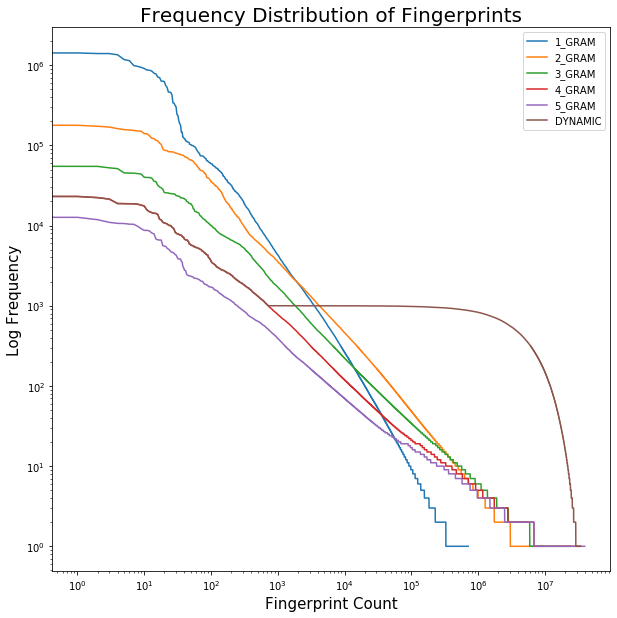

In [70]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Frequency Distribution of Fingerprints', fontsize=20)
ax.set_xlabel('Fingerprint Count', fontsize=15)
ax.set_ylabel('Log Frequency', fontsize=15)
ax.plot(x_axis[0], y_axis[0], label = "1_GRAM")
ax.plot(x_axis[1], y_axis[1], label = "2_GRAM")
ax.plot(x_axis[2], y_axis[2], label = "3_GRAM")
ax.plot(x_axis[3], y_axis[3], label = "4_GRAM")
ax.plot(x_axis[4], y_axis[4], label = "5_GRAM")
ax.plot(x_axis_dynamic, dynamic_counts, label = "DYNAMIC")
plt.legend(loc="upper right",fontsize = 13)

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Frequency Distribution of Fingerprints', fontsize=20)
ax.set_xlabel('Fingerprint Count', fontsize=15)
ax.set_ylabel('Log Frequency', fontsize=15)
ax.plot(x_axis[0], y_axis[0], label = "1_GRAM")
ax.plot(x_axis[1], y_axis[1], label = "2_GRAM")
ax.plot(x_axis[2], y_axis[2], label = "3_GRAM")
ax.plot(x_axis[3], y_axis[3], label = "4_GRAM")
ax.plot(x_axis[4], y_axis[4], label = "5_GRAM")
ax.plot(x_axis_dynamic, dynamic_counts, label = "DYNAMIC")
plt.legend(loc="upper right",fontsize = 13)

# Analysis 2

https://docs.google.com/spreadsheets/d/1qilXIht6Gv4270yWQ4cBar0GV4tf-C3qOWklVoLlE3M/edit#gid=0

# Analysis 3

In [5]:
length_file = "/home/dyang/lengths.txt"
rank_file = "/home/dyang/rank.txt"
num_lines_file = "/home/dyang/numLines.txt"
lengths = []
ranks = []
num_lines = []
with open (length_file, 'r') as f:
    for line in f:
        try:
            num = int(line.strip())
            lengths.append(num)
        except:
            pass
with open (rank_file, 'r') as f:
    for line in f:
        try:
            num = int(line.strip())
            ranks.append(num)
        except:
            pass
with open (num_lines_file, 'r') as f:
    for line in f:
        try:
            num = int(line.strip())
            num_lines.append(num)
        except:
            pass
ranks = np.array(ranks)
ranks = 1/ranks
lengths = np.array(lengths)
num_lines = np.array(num_lines)

No handles with labels found to put in legend.


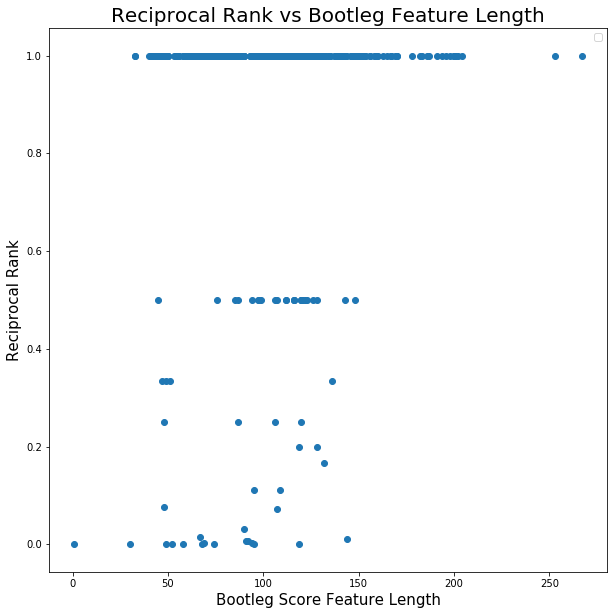

In [6]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Reciprocal Rank vs Bootleg Feature Length', fontsize=20)
ax.set_xlabel('Bootleg Score Feature Length',fontsize=15)
ax.set_ylabel('Reciprocal Rank',fontsize=15)
ax.scatter(lengths, ranks)
plt.legend(loc="upper right")

No handles with labels found to put in legend.


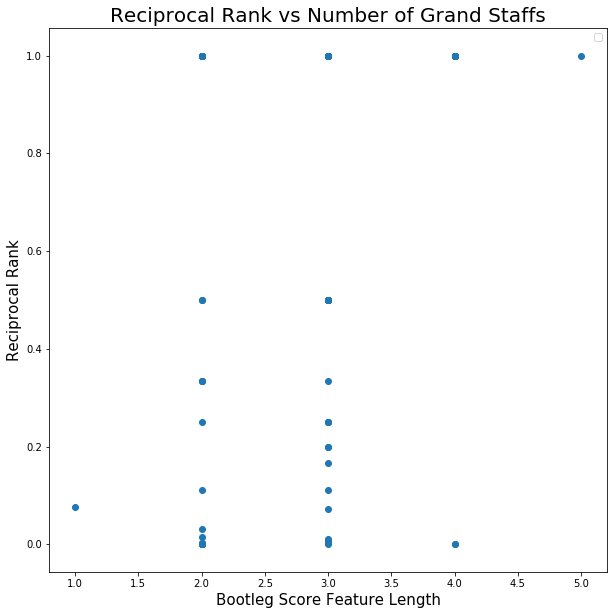

In [7]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Reciprocal Rank vs Number of Grand Staffs', fontsize=20)
ax.set_xlabel('Bootleg Score Feature Length',fontsize=15)
ax.set_ylabel('Reciprocal Rank',fontsize=15)
ax.scatter(num_lines, ranks)
plt.legend(loc="upper right")

In [ ]:
y1 = []
y2 = []
for i in range(5):
    x = np.where(num_lines==i+1)[0]
    ranks_tmp = ranks[x]
    ranks_1 = np.where(ranks_tmp>0.9)[0]
    ranks_2 = np.where(ranks_tmp<0.9)[0]
    y1.append(len(ranks_1))
    y2.append(len(ranks_2))
x = [1,2,3,4,5]
print(x,y1,y2)



fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('', fontsize=10)
ax.set_ylabel('Bootleg Score Length')
ax.set_ylabel('Reciprocal Rank')
p1 = ax.bar(x, y1)
p2 = ax.bar(x,y2,bottom=y1)
ax.scatter(num_lines, ranks)
plt.legend((p1[0], p2[0]), ('Reciprocal Rank 1', 'Reciprocal Rank Not 1'), loc="upper right", fontsize=15)

# Analysis 4

In [3]:
import librosa as lb

In [4]:
arr1 = [1, 2, 3, 4]
arr2 = [100, 1, 2, 100, 3, 100, 4]

In [5]:
score = np.min(lb.sequence.dtw(arr1, arr2, subseq=True, backtrack=False,
                               step_sizes_sigma=np.array([[1,1],[1,2], [2,1]]), 
                               weights_mul=np.array([1,1,2]))[-1])
score

0.0

In [4]:
def readHypothesisFiles(hypdir, benchmark):
    l = []
    if benchmark == 1:
        for hypfile in sorted(glob.glob("{}/*.pkl".format(hypdir))):
            with open(hypfile, "rb") as f:
                l.append([os.path.splitext(os.path.basename(hypfile))[0],pickle.load(f)])
    elif benchmark == 0 or benchmark == 2:
        for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
            print(hypfile)
            with open(hypfile, "rb") as f:
                l.append(pickle.load(f))
    elif benchmark == 3:
        for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
            print(hypfile)
            with open(hypfile, "rb") as f:
                data = pickle.load(f)
                pieceScores = [(x[1],x[0]) for x in data[1]]
                l.append((data[0],pieceScores))
    return l

In [5]:
hypdir = 'experiments/DynamicStatic1k/hyp'
hyps = readHypothesisFiles(hypdir, 0)

experiments/DynamicStatic1k/hyp/p101_q1.hyp
experiments/DynamicStatic1k/hyp/p101_q10.hyp
experiments/DynamicStatic1k/hyp/p101_q2.hyp
experiments/DynamicStatic1k/hyp/p101_q3.hyp
experiments/DynamicStatic1k/hyp/p101_q4.hyp
experiments/DynamicStatic1k/hyp/p101_q5.hyp
experiments/DynamicStatic1k/hyp/p101_q6.hyp
experiments/DynamicStatic1k/hyp/p101_q7.hyp
experiments/DynamicStatic1k/hyp/p101_q8.hyp
experiments/DynamicStatic1k/hyp/p101_q9.hyp
experiments/DynamicStatic1k/hyp/p105_q1.hyp
experiments/DynamicStatic1k/hyp/p105_q10.hyp
experiments/DynamicStatic1k/hyp/p105_q2.hyp
experiments/DynamicStatic1k/hyp/p105_q3.hyp
experiments/DynamicStatic1k/hyp/p105_q4.hyp
experiments/DynamicStatic1k/hyp/p105_q5.hyp
experiments/DynamicStatic1k/hyp/p105_q6.hyp
experiments/DynamicStatic1k/hyp/p105_q7.hyp
experiments/DynamicStatic1k/hyp/p105_q8.hyp
experiments/DynamicStatic1k/hyp/p105_q9.hyp
experiments/DynamicStatic1k/hyp/p111_q1.hyp
experiments/DynamicStatic1k/hyp/p111_q10.hyp
experiments/DynamicStatic1k/h

experiments/DynamicStatic1k/hyp/p1_q3.hyp
experiments/DynamicStatic1k/hyp/p1_q4.hyp
experiments/DynamicStatic1k/hyp/p1_q5.hyp
experiments/DynamicStatic1k/hyp/p1_q6.hyp
experiments/DynamicStatic1k/hyp/p1_q7.hyp
experiments/DynamicStatic1k/hyp/p1_q8.hyp
experiments/DynamicStatic1k/hyp/p1_q9.hyp
experiments/DynamicStatic1k/hyp/p21_q1.hyp
experiments/DynamicStatic1k/hyp/p21_q10.hyp
experiments/DynamicStatic1k/hyp/p21_q2.hyp
experiments/DynamicStatic1k/hyp/p21_q3.hyp
experiments/DynamicStatic1k/hyp/p21_q4.hyp
experiments/DynamicStatic1k/hyp/p21_q5.hyp
experiments/DynamicStatic1k/hyp/p21_q6.hyp
experiments/DynamicStatic1k/hyp/p21_q7.hyp
experiments/DynamicStatic1k/hyp/p21_q8.hyp
experiments/DynamicStatic1k/hyp/p21_q9.hyp
experiments/DynamicStatic1k/hyp/p25_q1.hyp
experiments/DynamicStatic1k/hyp/p25_q10.hyp
experiments/DynamicStatic1k/hyp/p25_q2.hyp
experiments/DynamicStatic1k/hyp/p25_q3.hyp
experiments/DynamicStatic1k/hyp/p25_q4.hyp
experiments/DynamicStatic1k/hyp/p25_q5.hyp
experiments/Dyna

In [6]:
def decodeColumn(num):
    col = []
    for i in range(62):
        col.insert(0,num%2)
        num = int(num/2)
    return col

In [7]:
def getTotalBscore(bscore_file):
    bscore_array = []
    with open (bscore_file,'rb') as f:
        bscore_array = pickle.load(f)
    f.close()
    total_bscore = np.array([]).reshape(62,0)
    page_array = []
    for page in bscore_array:
        total_page = np.array([]).reshape(62,0)
        for num in page:
            col = np.array(decodeColumn(num)).reshape(62,-1)
            total_page = np.concatenate((total_page,col),axis=1)
        total_bscore = np.concatenate((total_bscore,total_page),axis=1)
        page_array.append(total_page)
    return total_bscore,page_array

In [8]:
def name_to_bootleg(name):
    basedir = "/home/dyang/SheetMidiSearchRetrieval/experiments/bootleg_output/"
    path = os.path.join(basedir, name)+'.pkl'
    return path

In [9]:
name_to_bootleg(hyps[0][0])

'/home/dyang/SheetMidiSearchRetrieval/experiments/bootleg_output/p101_q1.pkl'

In [10]:
def bootlegHash(arr):
    bitstring = ""
    for i in range(len(arr)):
        if arr[i]==1:
            bitstring+="1"
        else:
            bitstring +="0"
    bitstring = bitstring+"00"
    hashint = int(bitstring, 2)
    hashint = np.uint64(hashint)
    return hashint

In [47]:
def getPaths(hyps):
    outdir = "experiments/DTW/hyp"
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    hyps = sorted(hyps, key = lambda x: int(x[0].split("_")[0][1:])*100+int(x[0].split("_")[1][1:]))
    for index, (queryid, pieceScores) in enumerate(hyps):
        if queryid!="p45_q6":
            continue
        try:
            start = time.time()
            scores = []
            N = 5
            for i in range(N):
                query=processQuery(os.path.join("data/queries",queryid)+'.jpg')
                path = name_to_bootleg(pieceScores[i][0])
                num = path.split('/')[-1][0]
                if(num == 'd'):
                    data, _ = getTotalBscore(path)
                else:
                    with open(path, 'rb') as pickle_file:
                        data = pickle.load(pickle_file)
                hashed_data = []
                hashed_query = []

                for colindex in range(len(data.T)):
                    first_col = data.T[colindex]
                    first_fp = bootlegHash(first_col)
                    hashed_data.append(first_fp)

                for colindex in range(len(query.T)):
                    first_col = query.T[colindex]
                    first_fp = bootlegHash(first_col)
                    hashed_query.append(first_fp)

                c1 = time.time()

                score = np.min(lb.sequence.dtw(hashed_query, hashed_data, subseq=True, backtrack=False,
                               step_sizes_sigma=np.array([[1,1],[1,2], [2,1]]), 
                               weights_mul=np.array([1,1,2]))[-1])
                print(len(hashed_data), len(hashed_query))
                c2 = time.time()
                print(c1-start,c2-start)
                scores.append(score)
            print(time.time()-start)
            n_hyps = pieceScores[:N]
            scores, n_hyps = zip(*sorted(zip(scores, n_hyps)))
            pieceScores1 = copy.copy(pieceScores)
            for idx, item in enumerate(n_hyps):
                pieceScores1[idx] = item
            hyps[index] = (queryid, pieceScores1)
            outfile = os.path.join(outdir, queryid)+".hyp"
            print(pieceScores[:5])
            print(pieceScores1[:5])
            with open(outfile, 'wb') as f:
                pickle.dump(hyps[index], f)
        except:
            pass
        

In [48]:
getPaths(hyps)

Processing data/queries/p45_q6.jpg
323 67
4.4895594120025635 4.492590427398682
Processing data/queries/p45_q6.jpg
1151 67
8.693554639816284 8.702614784240723
Processing data/queries/p45_q6.jpg
3604 67
12.779043436050415 12.832249641418457
Processing data/queries/p45_q6.jpg
6073 67
19.96980595588684 20.097387552261353
Processing data/queries/p45_q6.jpg
2866 67
25.698405504226685 25.748276948928833
25.748717308044434
[('p45', 18), ('dB%C4%85darzewska-Baranowska,_TeklaL%27%C3%A9cho_des_bois_**79562', 5), ('dTchaikovsky,_PyotrTheme_with_Variations_in_A_minor_**12785', 3), ('dFibich,_Zden%C4%9BkMoods,_Impressions,_and_Souvenirs,_Op.47_**71601', 3), ('dSchumann,_Robert7_Klavierst%C3%BCcke_in_Fughettenform,_Op.126_**51586', 3)]
[('dB%C4%85darzewska-Baranowska,_TeklaL%27%C3%A9cho_des_bois_**79562', 5), ('dTchaikovsky,_PyotrTheme_with_Variations_in_A_minor_**12785', 3), ('dFibich,_Zden%C4%9BkMoods,_Impressions,_and_Souvenirs,_Op.47_**71601', 3), ('dSchumann,_Robert7_Klavierst%C3%BCcke_in_Fughet

In [109]:
Processing data/queries/p1_q1.jpg
7834557480960.0
196919904434432
Processing data/queries/p1_q2.jpg
20890866008064.0
277675139874816.0
Processing data/queries/p1_q3.jpg
554051567616.0
Processing data/queries/p1_q4.jpg

Processing data/queries/p1_q1.jpg
196919904434432.0
Processing data/queries/p1_q2.jpg
277675139874816.0
Processing data/queries/p1_q3.jpg
404305063870464.0
Processing data/queries/p1_q4.jpg
2900244654424064.0
Processing data/queries/p1_q5.jpg

SyntaxError: invalid syntax (<ipython-input-109-e5f5d654a360>, line 1)